In [ ]:
import torch
import pandas as pd

from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer

from utils.dataset import MovieDataset
from utils.models import MLPRegressor

In [ ]:
movie_df = pd.concat([pd.read_csv('../resource/dataset/train_data/test_data.csv', index_col=0),
                      pd.read_csv('../resource/dataset/train_data/train_data.csv', index_col=0)], axis=0).sort_index()
dataset = MovieDataset(movie_df)

In [ ]:
disbert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased')
disbert = AutoModel.from_pretrained('distilbert-base-cased')
disbert.eval()
if torch.cuda.is_available():
    disbert.cuda()

In [ ]:
checkpoint = torch.load('../resource/model_checkpoints/mlp_model_cp2.tar', map_location='cpu')

mlp_model = MLPRegressor(768 + dataset[0][0].shape[0])
mlp_model.load_state_dict(checkpoint['model'])
mlp_model.eval()
if torch.cuda.is_available():
    mlp_model.cuda()

In [ ]:
from tqdm import tqdm

predictions = []
pbar = tqdm(DataLoader(dataset, 512, shuffle=False))
with torch.no_grad():
  for stats, descript, _ in pbar:
      tokens = disbert_tokenizer(
          descript, return_tensors='pt',
          padding=True, truncation=True
      )
      if torch.cuda.is_available():
          token_ids = tokens['input_ids'].cuda()
          token_mask = tokens['attention_mask'].cuda()
          stats = stats.cuda()
      embeddings = disbert(token_ids, token_mask)['last_hidden_state'][:, 0, :]

      predictions.append(
          mlp_model(torch.concat([stats, embeddings], axis=1)).cpu().numpy()
      )

100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.DataFrame(np.concat(predictions), columns=['predicted_rating'])
df.to_csv('predictions.csv', float_format="%.8f")

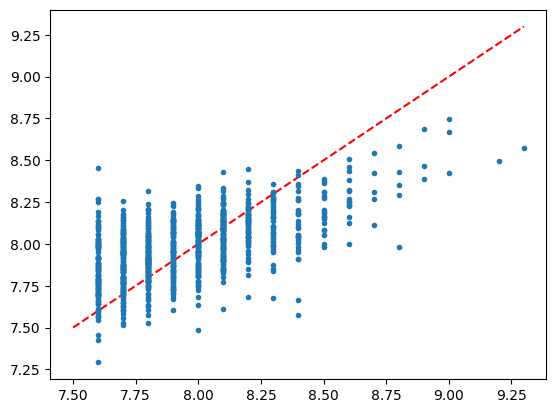

In [ ]:
plt.plot([7.5, 9.3], [7.5, 9.3], '--r')
plt.plot(movie_df['IMDB_Rating'].to_numpy(), np.concat(predictions), '.');